In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns  
import tensorflow as tf  
from tensorflow import keras  
from tensorflow.keras import Layer 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  
from sklearn.utils.class_weight import compute_class_weight  
from tensorflow.keras.applications import EfficientNetV2B2 
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr 

In [2]:
dataset_dir= r"C:\Users\Edunet Foundation\Downloads\project\garbage\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(val_ds) 
test_ds = val_ds.take(val_batches // 2)  
val_dat = val_ds.skip(val_batches // 2)  
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)  

In [6]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


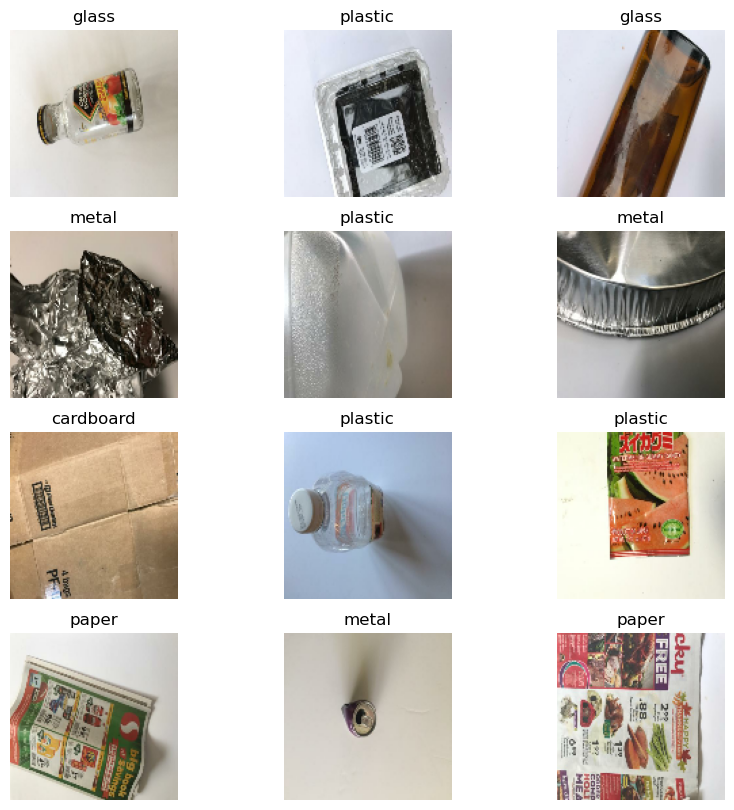

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [8]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}
    
    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  
    return counts

In [9]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [10]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


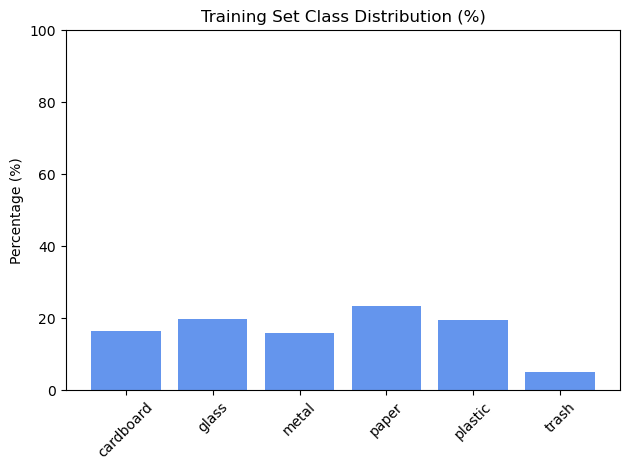

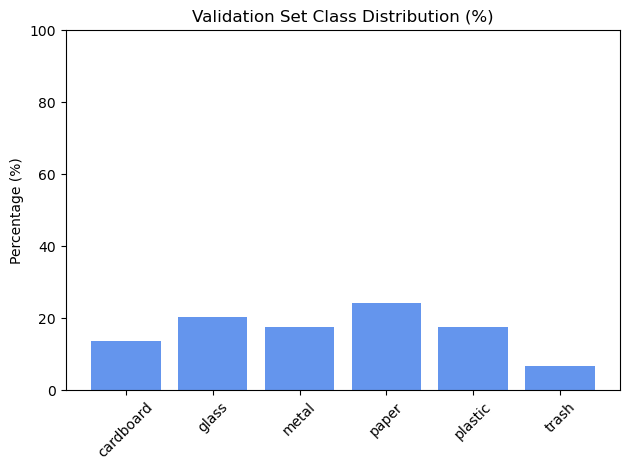

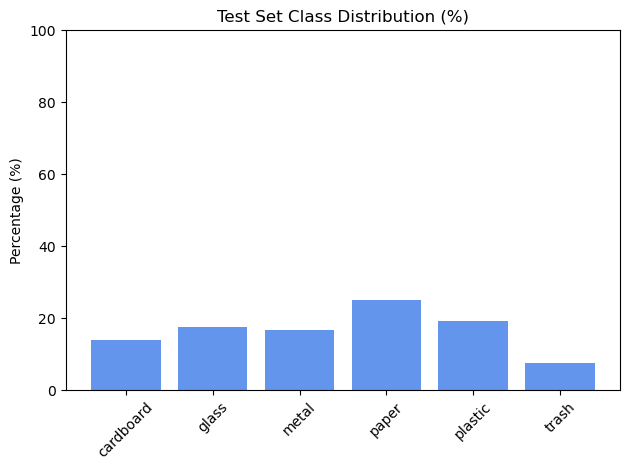

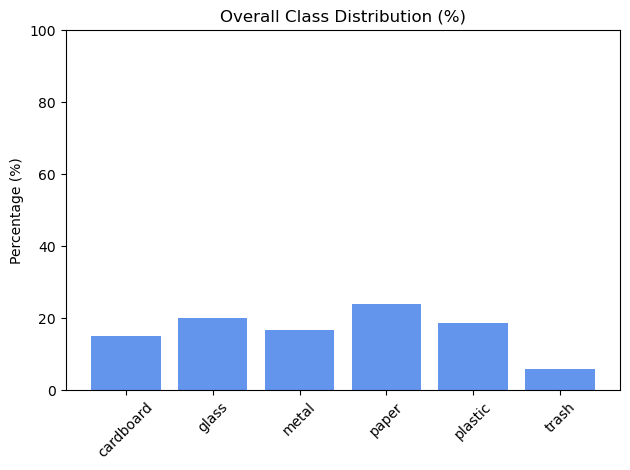

In [11]:
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [12]:
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

class_weights = {i: w for i, w in enumerate(class_weights_array)}

print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: 1.0089820359281436, 1: 0.8446115288220551, 2: 1.046583850931677, 3: 0.7154989384288747, 4: 0.8575063613231552, 5: 3.2718446601941746}


In [13]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

In [14]:
base_model = EfficientNetV2B2(include_top=False, input_shape=(124, 124, 3),include_preprocessing=True, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:100]:  
    layer.trainable = False

In [15]:
model = Sequential([
    layers.Input(shape=(124, 124, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  
])

In [16]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            
    patience=3,                  
    restore_best_weights=True     
)

In [18]:
epochs = 20

history = model.fit(
    train_ds,                
    validation_data=val_ds,   
    epochs=epochs,           
    class_weight=class_weights,  
    batch_size=32,           
    callbacks=[early]
)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 207s 2s/step - accuracy: 0.2841 - loss: 1.7339 - val_accuracy: 0.6218 - val_loss: 1.2028
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6541 - loss: 1.1145 - val_accuracy: 0.7762 - val_loss: 0.8160
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.7727 - loss: 0.7509 - val_accuracy: 0.8455 - val_loss: 0.5781
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8361 - loss: 0.5076 - val_accuracy: 0.8733 - val_loss: 0.4780
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8809 - loss: 0.3761 - val_accuracy: 0.8891 - val_loss: 0.3960
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9046 - loss: 0.2856 - val_accuracy: 0.8851 - val_loss: 0.3676
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9339 - loss: 0.2339 - val_accuracy: 0.8792 - val_loss: 0.3524
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9446 - loss: 0.1783 - val_accuracy: 0.8931 - v

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 124, 124, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-b2 (Functional)       │ (None, 4, 4, 1408)          │       8,769,374 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │           8,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [20]:
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 124, 124, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling (Rescaling)         │ (None, 124, 124, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization (Normalization) │ (None, 124, 124, 3)       │               0 │ rescaling[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 62, 62, 32)        │             864 │ normalization[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 62, 62, 32)        │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 62, 62, 32)        │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_conv (Conv2D) │ (None, 62, 62, 16)        │           4,608 │ stem_activation[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_bn            │ (None, 62, 62, 16)        │              64 │ block1a_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_project_activation    │ (None, 62, 62, 16)        │               0 │ block1a_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_conv (Conv2D) │ (None, 62, 62, 16)        │           2,304 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_bn            │ (None, 62, 62, 16)        │              64 │ block1b_project_conv[0][0] │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_project_activation    │ (None, 62, 62, 16)        │               0 │ block1b_project_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_drop (Dropout)        │ (None, 62, 62, 16)        │               0 │ block1b_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1b_add (Add)             │ (None, 62, 62, 16)        │               0 │ block1b_drop[0][0],        │
│                               │                           │                 │ block1a_project_activatio… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2a_expand_conv (Conv2D)  │ (None, 31, 31, 64)        │           9,21

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

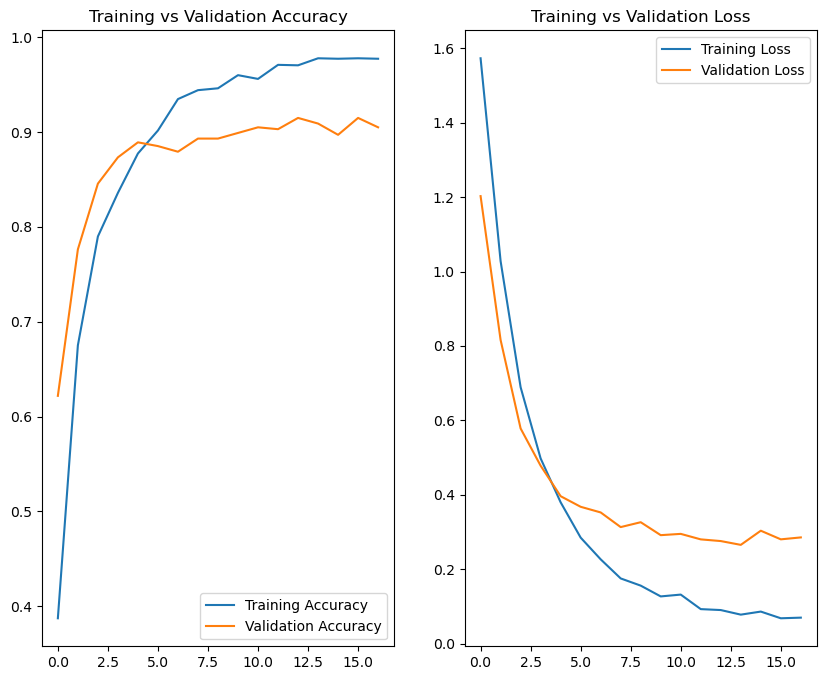

In [ ]:
acc = history.history['accuracy']          
val_acc = history.history['val_accuracy']  
loss = history.history['loss']             
val_loss = history.history['val_loss']     

epochs_range = range(len(acc))            

plt.figure(figsize=(10,8))                 

plt.subplot(1,2,1)                        
plt.plot(epochs_range, acc, label='Training Accuracy')      
plt.plot(epochs_range, val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right')              
plt.title('Training vs Validation Accuracy') 

plt.subplot(1,2,2)                        
plt.plot(epochs_range, loss, label='Training Loss')         
plt.plot(epochs_range, val_loss, label='Validation Loss')   
plt.legend(loc='upper right')              
plt.title('Training vs Validation Loss')   

plt.show()  

In [22]:
loss, accuracy = model.evaluate(test_ds_eval)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 538ms/step - accuracy: 0.9224 - loss: 0.2219
Test accuracy is0.9258, Test loss is 0.2227


In [23]:
y_true = np.concatenate([y.numpy() for x, y in test_ds_eval], axis=0)  

y_pred_probs = model.predict(test_ds_eval)  

y_pred = np.argmax(y_pred_probs, axis=1)  

cm = confusion_matrix(y_true, y_pred)  

print(cm)  
print(classification_report(y_true, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step
[[28  0  0  3  0  0]
 [ 0 47  2  0  1  0]
 [ 0  2 39  1  0  1]
 [ 1  0  0 63  0  1]
 [ 0  3  0  0 40  2]
 [ 0  0  1  1  0 20]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.93        31
           1       0.90      0.94      0.92        50
           2       0.93      0.91      0.92        43
           3       0.93      0.97      0.95        65
           4       0.98      0.89      0.93        45
           5       0.83      0.91      0.87        22

    accuracy                           0.93       256
   macro avg       0.92      0.92      0.92       256
weighted avg       0.93      0.93      0.93       256



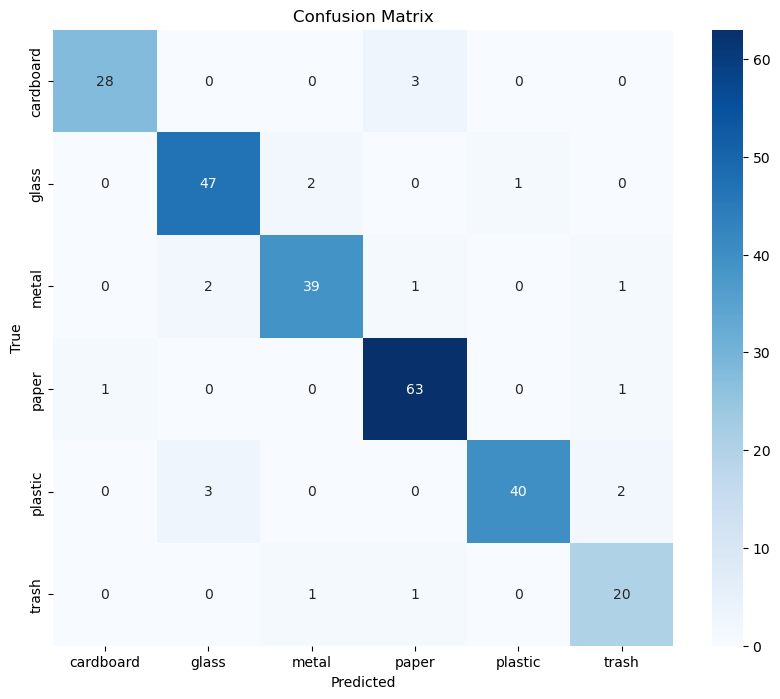

In [24]:
plt.figure(figsize=(10,8))  

sns.heatmap(cm, annot=True, fmt='d',  
            xticklabels=class_names,  
            yticklabels=class_names,
            cmap='Blues')  

plt.xlabel('Predicted')  
plt.ylabel('True')  
plt.title('Confusion Matrix')  
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


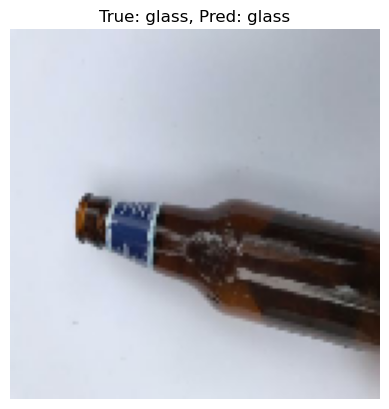

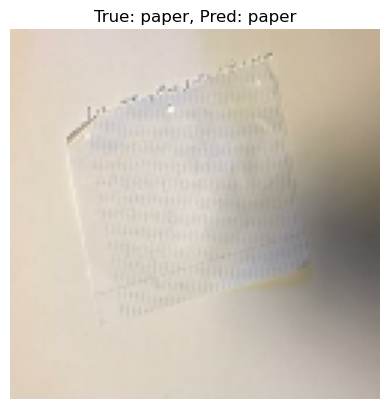

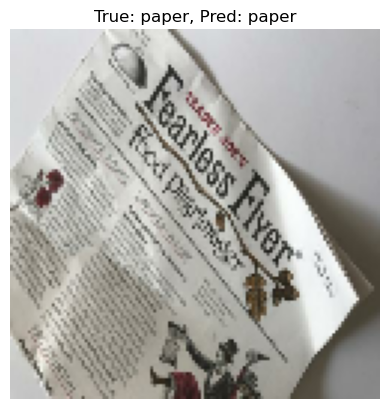

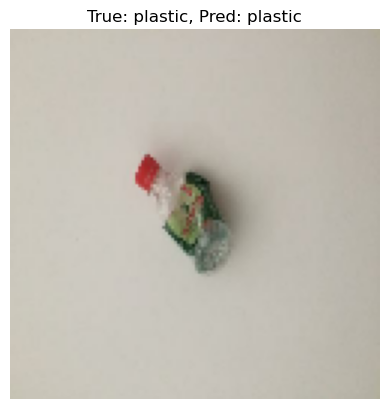

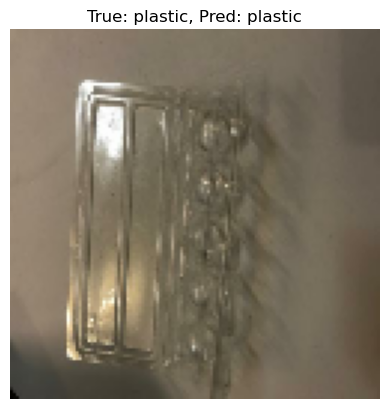

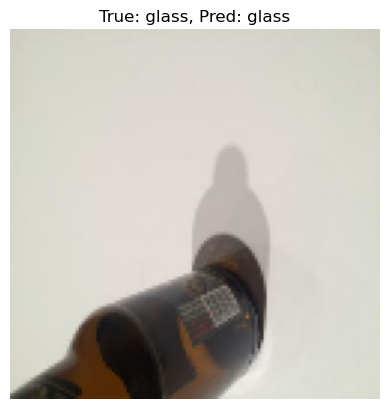

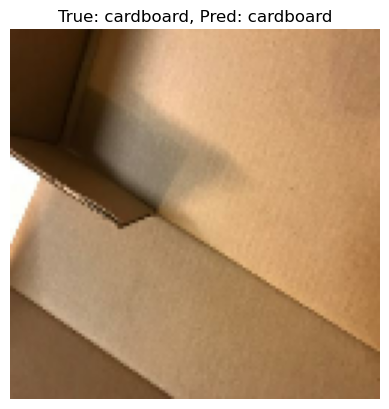

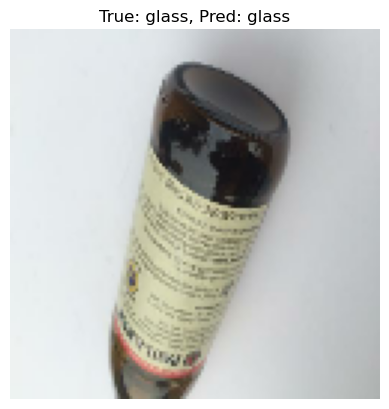

In [25]:
class_names = train_ds.class_names  

for images, labels in test_ds_eval.take(1):  

    predictions = model.predict(images)
    
    pred_labels = tf.argmax(predictions, axis=1)  

    for i in range(8):  
        plt.imshow(images[i].numpy().astype("uint8")) 
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  
        plt.axis("off")  
        plt.show() 

In [26]:
model.save('Effiicientnetv2b2.keras')

model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

In [27]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [28]:
def classify_image(img):  
    img = img.resize((124, 124))  
    
    img_array = np.array(img, dtype=np.float32)  
    
    img_array = preprocess_input(img_array)
    
    img_array = np.expand_dims(img_array, axis=0)  
    
    prediction = model.predict(img_array)  
    
    predicted_class_index = np.argmax(prediction)  
    
    predicted_class_name = class_names[predicted_class_index]  
    
    confidence = prediction[0][predicted_class_index]  
    
    return f"Predicted: {predicted_class_name} (Confidence: {confidence:.2f})"  

In [29]:
iface = gr.Interface(  
    fn=classify_image,  
    inputs=gr.Image(type="pil"),   
    outputs="text"  
)  

iface.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
